# Test outputting the light curves

In [68]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import csv
import os
import pandas as pd
import pickle

import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from OpSim import OpSim
from newLSSTEBWorker import LSSTEBWorker 

from matplotlib import pyplot as plt
#%matplotlib notebook
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pick an OpSim field

In [35]:
filters = ['u_', 'g_', 'r_', 'i_', 'z_', 'y_']

In [2]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/baseline2018a.db'
OpS.getAllOpSimFields()

getting OpSim fields...
have summary cursor.
have field cursor.
returned 5292 fields


914.0


/Users/ageller/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:414: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


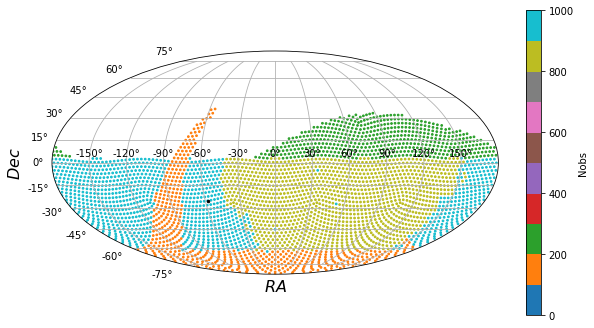

In [3]:
coords = SkyCoord(OpS.RA, OpS.Dec, unit=(u.degree, u.degree),frame='icrs')
lGal = coords.galactic.l.wrap_at(180.*u.degree).degree
bGal = coords.galactic.b.wrap_at(180.*u.degree).degree

raGal = coords.icrs.ra.wrap_at(180.*u.degree).degree
decGal = coords.icrs.dec.wrap_at(180.*u.degree).degree


f, ax = plt.subplots(subplot_kw={'projection': "mollweide"}, figsize=(10,8))
ax.grid(True)
ax.set_xlabel(r"$RA$",fontsize=16)
ax.set_ylabel(r"$Dec$",fontsize=16)
xx = np.where(OpS.Nobs > 0)
mlw = ax.scatter(raGal[xx]*np.pi/180.,decGal[xx]*np.pi/180., s = 3, c=OpS.Nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)
cbar = f.colorbar(mlw, shrink=0.7)
cbar.set_label(r'Nobs')
    
#choose some number
OpSimi = 1520
print(OpS.Nobs[OpSimi])
ax.scatter([raGal[OpSimi]*np.pi/180.],[decGal[OpSimi]*np.pi/180.], s = 6, c='black')


In [4]:
OpS.setDates(OpSimi, filters)

*The stuff above takes a while to run because of getting OpSim.*

## Set up the worker and get the Galaxy model

In [6]:
worker = LSSTEBWorker()
worker.OpSim = OpS
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
#worker.initialize(OpSimi) #this just sets the dates, but I already did that above

In [8]:
galDir = 'grid'
if not os.path.exists(galDir):
    os.makedirs(galDir)
worker.galDir = galDir
worker.getGalaxy(OpSimi, deleteModel = False, downloadModel = False) #already downloaded this one

downloading TRILEGAL model for ID=1521.0, RA=302.03318, DEC=-25.29462, Nstars=377029.0, Nstars/resEl=0.0005937090576971529


In [9]:
print(worker.Galaxy.model.sample())

       Gc  logAge  [M/H]    m_ini   logL  logTe   logg  m-M0     Av  m2/m1  \
25163   1    9.83  -0.37  1.10304  3.182   3.56  0.486  13.1  0.385    0.0   

        mbol   u_mag   g_mag   r_mag   i_mag  z_mag  Y_mag   Mact  logDist  
25163  9.915  16.344  12.999  11.497  10.508  10.01  9.648  1.103     0.62  


### Set up the output file

In [55]:
def writeLine(csvwriter, EB, LCfile):
    output = [EB.period, EB.m1, EB.m2, EB.r1, EB.r2, EB.eccentricity, EB.inclination, EB.dist, EB.nobs, 
              EB.AV, EB.M_H, EB.appMagMean['r_'], EB.maxDeltaMag, EB.deltaMag['r_'],
              EB.appmag_failed, EB.incl_failed, EB.period_failed, EB.radius_failed]
    
    #this is for gatspy
    for filt in filters:
        output.append(EB.LSS[filt]) 
    output.append(EB.LSM) 
    output.append(LCfile)
        
    csvwriter.writerow(output)

In [70]:
summaryFile = 'LC/summary_OpSim' + str(OpSimi).zfill(4) + '.csv'
csvfile = open(summaryFile, 'w')
csvwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
cols = ['p', 'm1', 'm2', 'r1', 'r2', 'e', 'i', 'd', 'nobs',
        'Av','[M/H]','appMagMean_r', 'maxDeltaMag', 'deltaMag_r',
        'mag_failure', 'incl_failure', 'period_failure', 'radius_failure', 
        'u_LSS_PERIOD', 'g_LSS_PERIOD', 'r_LSS_PERIOD', 'i_LSS_PERIOD', 'z_LSS_PERIOD', 'y_LSS_PERIOD', 'LSM_PERIOD',
        'LC_file']
csvwriter.writerow(cols)     

223

## Sample from the galaxy to get the binaries

In [ ]:
nOut = 10
nFinished = 0
magLims = [15.8, 19.5] #prsa limits

while nFinished < nOut:
    s = worker.Galaxy.model.sample()
    binary = worker.makeBinaryFromGalaxy(s)
    line = np.array([binary['m1'], 
            binary['m2'],
            binary['logp'],
            binary['ecc'],
            binary['rad1'],
            binary['rad2'],
            binary['lum1'],
            binary['lum2'], 
            0, 0, 0, 
            binary['dist'],
            binary['inc'],
            binary['OMEGA'],
            binary['omega'],
            binary['Av'],
            binary['MH'],
            binary['teff1'],
            binary['teff2'],
            binary['logg1'],
            binary['logg2'],
            binary['rmag']])
    EB = worker.getEB(line, OpSimi=OpSimi)
    EB.magLims = magLims
    fname = None
    if (EB.observable):
        worker.return_dict[0] = EB
        worker.run_ellc(0)
        worker.run_gatspy(0)
        EB = worker.return_dict[0]
        fname = 'LC/ellc_OpSim' + str(OpSimi).zfill(4) + '_' + str(nFinished).zfill(4)+'.pickle'
        EB.outputLCtoFile(fname)
        nFinished += 1
    writeLine(csvwriter, EB, fname)
    
csvfile.close()

## Test the output files

In [65]:
summary = pd.read_csv(summaryFile)
summary

,p,m1,m2,r1,r2,e,i,d,nobs,Av,...,period_failure,radius_failure,u_LSS_PERIOD,g_LSS_PERIOD,r_LSS_PERIOD,i_LSS_PERIOD,z_LSS_PERIOD,y_LSS_PERIOD,LSM_PERIOD,LC_file
0,329.584081,1.361,1.032,1.876994,1.337746,0.863682,142.571883,0.831764,0,0.346,...,0,0,-999.000000,-999.000000,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,NaN
1,0.070578,0.562,0.353,0.506876,0.332216,0.652091,102.499847,6.025596,0,0.378,...,0,1,-999.000000,-999.000000,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,NaN
2,2.011980,0.572,0.108,0.507261,0.132662,0.338691,91.631171,10.000000,914,0.377,...,0,0,-999.000000,8.686253,0.579249,0.21956,0.245256,0.311330,0.258898,LC/ellc_OpSim1520_0000.pickle
3,28.108560,0.452,0.180,0.401886,0.183514,0.501873,99.228300,1.659587,0,0.413,...,0,0,-999.000000,-999.000000,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,NaN
4,128.197238,0.710,0.197,0.728892,0.199649,0.081668,28.312201,5.495409,0,0.360,...,0,0,-999.000000,-999.000000,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,NaN
5,582.037562,0.699,0.656,0.681196,0.601846,0.076708,106.359673,9.549926,0,0.403,...,0,0,-999.000000,-999.000000,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,NaN
6,252.239061,0.618,0.550,0.554662,0.481078,0.934482,99.528042,5.248075,0,0.325,...,0,0,-999.000000,-999.000000,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,NaN
7,2050.495487,0.425,0.150,0.364946,0.176027,0.357160,68.450779,3.801894,0,0.404,...,0,0,-999.000000,-999.000000,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,NaN
8,16.590848,0.599,0.097,0.546069,0.185106,0.718294,48.894591,3.981072,0,0.367,...,0,0,-999.000000,-999.000000,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,NaN
9,909.768878,0.452,0.099,0.392738,0.152003,0.963027,40.528469,6.918310,0,0.363,...,0,0,-999.000000,-999.000000,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,NaN


Text(0.5, 0, 'q')

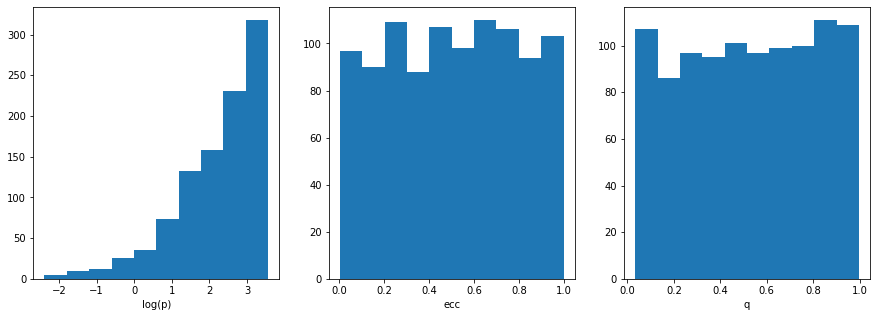

In [66]:
f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
_ = ax1.hist(np.log10(summary['p']))
ax1.set_xlabel('log(p)')

_ = ax2.hist(summary['e'])
ax2.set_xlabel('ecc')

_ = ax3.hist(summary['m2']/summary['m1'])
ax3.set_xlabel('q')

p                                       2.01198
m1                                        0.572
m2                                        0.108
r1                                     0.507261
r2                                     0.132662
e                                      0.338691
i                                       91.6312
d                                            10
nobs                                        914
Av                                        0.377
[M/H]                                     -1.61
appMagMean_r                            22.1619
maxDeltaMag                             10.8035
deltaMag_r                              3.94177
mag_failure                                   0
incl_failure                                  0
period_failure                                0
radius_failure                                0
u_LSS_PERIOD                               -999
g_LSS_PERIOD                            8.68625
r_LSS_PERIOD                           0

p                                      0.370825
m1                                         0.39
m2                                        0.097
r1                                     0.333093
r2                                     0.172552
e                                      0.469013
i                                       94.9739
d                                       7.24436
nobs                                        914
Av                                        0.294
[M/H]                                     -1.71
appMagMean_r                             22.902
maxDeltaMag                             20.2747
deltaMag_r                              7.75139
mag_failure                                   0
incl_failure                                  0
period_failure                                0
radius_failure                                0
u_LSS_PERIOD                               -999
g_LSS_PERIOD                           0.300924
r_LSS_PERIOD                           0

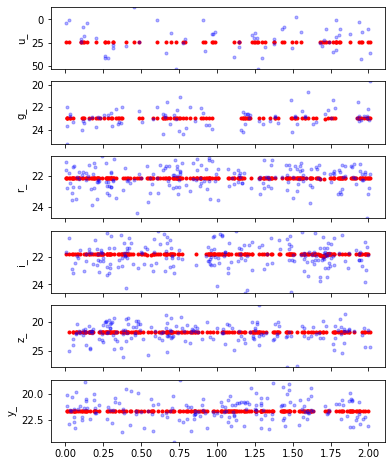

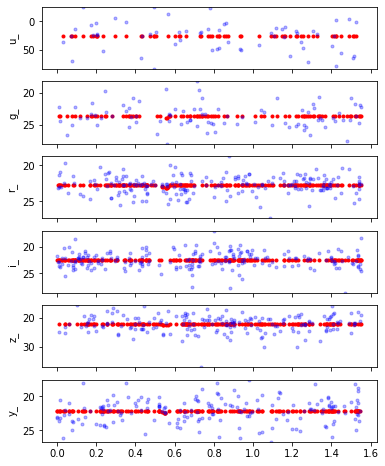

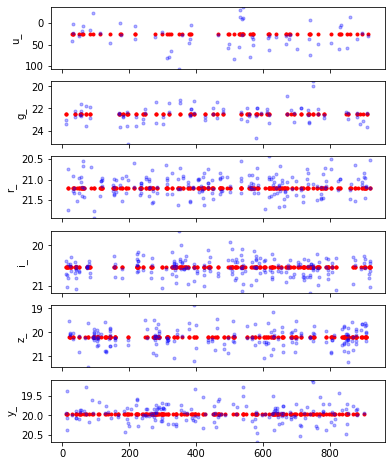

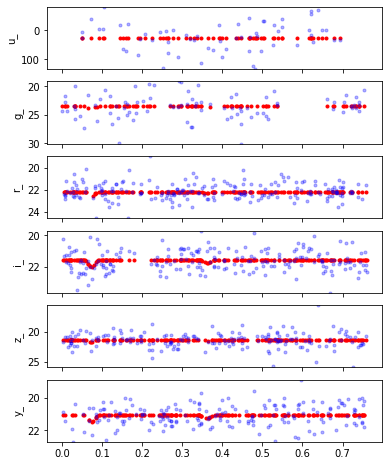

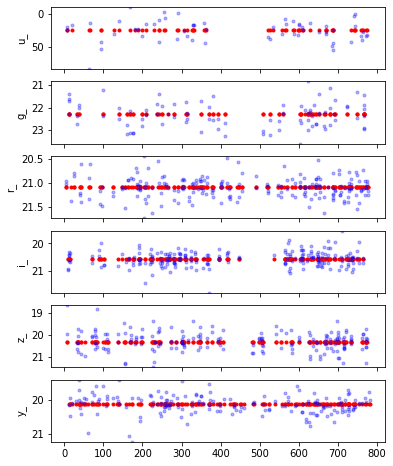

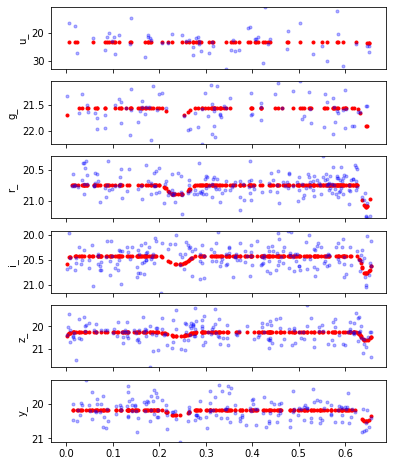

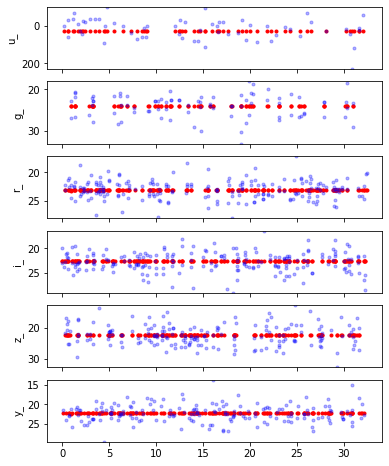

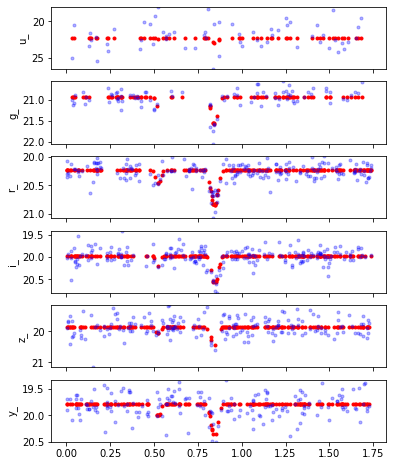

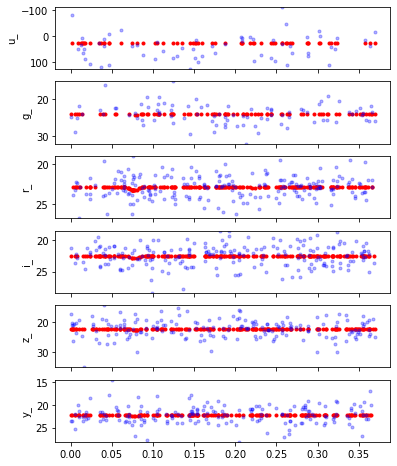

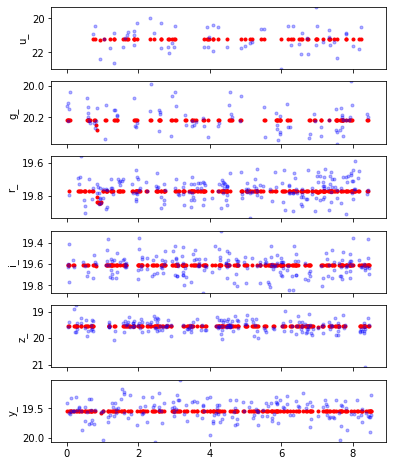

In [67]:
for index, row in summary.iterrows():
    if (not pd.isna(row['LC_file'])):
        print(row)
        file = open(row['LC_file'], 'rb')
        lc = pickle.load(file)
        file.close()
        fig,ax = plt.subplots(6,1, figsize=(6,8), sharex = True)
        for i,f in enumerate(filters):
            ax[i].plot((lc[f]['OpSimDates'] % row['p']), lc[f]['mag'],'.', color='red')
            ax[i].plot((lc[f]['OpSimDates'] % row['p']), lc[f]['magObs'],'.', alpha=0.3, color='blue')
            ax[i].set_ylim(max(lc[f]['magObs']), min(lc[f]['magObs']))
            ax[i].set_ylabel(f)
        